# <center style="font-size:140%;"> Report - Problem Set #*2*
 <center> Group Members:  Giacomo Martiriggiano, Mattia Gallese, Sophie De Becker, Yao Di

This Jupyter Notebook will outline the data cleaning process and binary classification for the churn factor of customers.csv for the assignment

## Data loading 

In [1]:
#import modules needed for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
#read the csv file to transfer all the data into "data"
data = pd.read_csv('customers.csv')

## Data Cleaning
We keep the data cleaning process as what we did for the Problem Set 1.
The first step is to remove the empty value in the TotalCharges column

In [2]:
data['TotalCharges'] = data['TotalCharges'].replace(" ", np.nan).astype('float32') 
data["SeniorCitizen"]=data["SeniorCitizen"].astype("object")
data = data[data["TotalCharges"].notnull()]
data = data.reset_index()[data.columns]
#now we forced the 0 and 1 to be objects and we know we can drop the empty values in Total charger 

Finally a number may be non-empty but still unrealistic for example negative tenure. Let's now check that tenure and charges are non negative

In [3]:
print((data['tenure'] <0).any())
print((data['TotalCharges']<0).any())
print((data['MonthlyCharges']<0).any())

False
False
False


We also need to encode the inputs from enumerates to numbers

### Logistic regression MonthlyCharges

In [12]:
data_origin = data.copy()
data_origin.Churn.replace({'No': 0, 'Yes': 1})
y=data_origin['Churn'].values
X_LR = data.iloc[:, 1:20].values

X_train, X_test, y_train, y_test = train_test_split(X_LR, y,stratify=y, test_size=0.2)
X_train_1D = X_train[:, 18, np.newaxis]
X_test_1D = X_test[:, 18, np.newaxis]
classifier = LogisticRegression().fit(X_train_1D, y_train)

accuracy = classifier.score(X_test_1D, y_test)
print('Classification accuracy: {:.2f}%'.format(accuracy * 100))

Classification accuracy: 73.42%


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


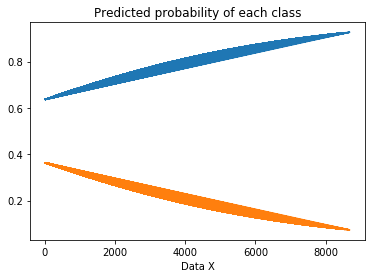

In [13]:
proba = classifier.predict_proba(X_LR[:,18,np.newaxis])
plt.plot(X_LR[:,18], proba)
plt.title('Predicted probability of each class')
plt.xlabel('Data X')
plt.show()

### Logistic regression tenure

In [14]:
X_train_1D = X_train[:, 5, np.newaxis]
X_test_1D = X_test[:, 5, np.newaxis]
classifier = LogisticRegression().fit(X_train_1D, y_train)

accuracy = classifier.score(X_test_1D, y_test)
print('Classification accuracy: {:.2f}%'.format(accuracy * 100))

C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'No'

In [15]:
proba = classifier.predict_proba(X[:,18,np.newaxis])
plt.plot(X[:,18], proba, '*')
plt.title('Predicted probability of each class')
plt.xlabel('Data X')
plt.show()

NameError: name 'X' is not defined

### Random Forest

In [ ]:
X = data.iloc[:, 1:20]
dfX= pd.get_dummies(X, columns= [i for i in X.columns if X[i].dtypes=='object'],drop_first=True)

y=data['Churn'].values
X_train, X_test, y_train, y_test = train_test_split(dfX, y,stratify=y, test_size=0.2)

classifier= RandomForestClassifier()
classifier.fit(X_train,y_train)
y_pred= classifier.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

## Data numerize and resampling
The key of the problem set is to develop a method to predict the performance of the customer. The prediction problem could be easily transfered to asup

The key output of our supervised learning model is the "Churn" parameter. The first step is to explore it.

In [ ]:
data_E2N = data[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']].copy()
data_E2N = data_E2N.apply(lambda x: pd.factorize(x)[0])
scaler = MinMaxScaler()
data_E2N = pd.DataFrame(scaler.fit_transform(data_E2N),columns=data_E2N.columns)
data_N = data[['tenure', 'MonthlyCharges', 'TotalCharges']].copy()
data_N['TotalCharges'] = pd.to_numeric(data_N['TotalCharges'])
scaler2 = StandardScaler()
data_N = pd.DataFrame(scaler2.fit_transform(data_N),columns=data_N.columns)
data_final = pd.concat([data_E2N, data_N], axis=1)

In [25]:
data_final.Churn.value_counts()

0.0    5163
1.0    1869
Name: Churn, dtype: int64

As we could observe, the dataset is not balanced based on the churn parameter. In order to get a reliable result, we need to downsampling the No Churn set of customer. 

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data_final, data_final["Churn"], stratify=data_final["Churn"],test_size=0.3)
count_nochurn, count_churn = x_train["Churn"].value_counts()

x_train_nochurn = x_train[x_train['Churn'] == 0.0]
x_train_churn = x_train[x_train['Churn'] == 1.0]

x_train_nochurn_resample = x_train_nochurn.sample(count_churn)
x_train_resample = pd.concat([x_train_nochurn_resample, x_train_churn], axis=0)

## Problem Solving

For the binary classification problem with multiple dimensions, support vector machine is a common solution to find a robust classifier

In [27]:
classifier = svm.SVC(gamma='auto')
classifier.fit(x_train_resample.drop(columns="Churn"), x_train_resample["Churn"])
y_predict=classifier.predict(x_test.drop(columns="Churn"))

In [28]:
print("The accuracy score for the classifier is :",accuracy_score(y_test,y_predict))
print("The recall score for the classifier is :",recall_score(y_test,y_predict,labels=[1,0]))
print("The precision score for the classifier is ::",precision_score(y_test,y_predict,labels=[1,0]))
pd.DataFrame(confusion_matrix(y_test,y_predict,labels=[1,0]), ["Churn_true","No Churn_true"], ["Churn_pred","No Churn_pred"])

The accuracy score for the classifier is : 0.7360189573459716
The recall score for the classifier is : 0.8235294117647058
The precision score for the classifier is :: 0.5021739130434782


,Churn_pred,No Churn_pred
Churn_true,462,99
No Churn_true,458,1091


### Cross Validation
We could add cross validation to ensure that our model is not overfitting

In [29]:
Accuracy_scores = []
Recall_scores = []
Precision_scores = []

k = 4
classifier = svm.SVC(gamma='auto')
cv = KFold(n_splits=k, random_state=42, shuffle=False)
for train_index, test_index in cv.split(data_final):
    x_train, x_test, y_train, y_test = data_final.iloc[train_index], data_final.iloc[test_index], data_final.Churn.iloc[train_index], data_final.Churn.iloc[test_index]
    
    x_train_nochurn = x_train[x_train['Churn'] == 0.0]
    x_train_churn = x_train[x_train['Churn'] == 1.0]

    x_train_nochurn_resample = x_train_nochurn.sample(count_churn)
    x_train_resample = pd.concat([x_train_nochurn_resample, x_train_churn], axis=0)
    
    classifier.fit(x_train_resample.drop(columns="Churn"), x_train_resample["Churn"])
    y_predict=classifier.predict(x_test.drop(columns="Churn"))
    Accuracy_scores.append(accuracy_score(y_test,y_predict))
    Recall_scores.append(recall_score(y_test,y_predict,labels=[1,0]))
    Precision_scores.append(precision_score(y_test,y_predict,labels=[1,0]))
    print(pd.DataFrame(confusion_matrix(y_test,y_predict,labels=[1,0]), ["Churn_true","No Churn_true"], ["Churn_pred","No Churn_pred"]))

print("The accuracy scores for the ",k, "-fold classifier is :",Accuracy_scores)
print("The recall scores for the ",k, "-fold classifier is :",Recall_scores)
print("The precision scores for the ",k, "-fold classifier is :",Precision_scores)

               Churn_pred  No Churn_pred
Churn_true            395             65
No Churn_true         431            867
               Churn_pred  No Churn_pred
Churn_true            377             80
No Churn_true         359            942
               Churn_pred  No Churn_pred
Churn_true            370             96
No Churn_true         437            855
               Churn_pred  No Churn_pred
Churn_true            394             92
No Churn_true         400            872
The accuracy scores for the  4 -fold classifier is : [0.7178612059158134, 0.7502844141069397, 0.6968145620022753, 0.7201365187713311]
The recall scores for the  4 -fold classifier is : [0.8586956521739131, 0.824945295404814, 0.7939914163090128, 0.8106995884773662]
The precision scores for the  4 -fold classifier is : [0.4782082324455206, 0.5122282608695652, 0.45848822800495664, 0.49622166246851385]


### Grid Search

In [ ]:
param_grid = [
  {'C': [1, 3, 10, 30, 100], 'kernel': ['linear']},
  {'C': [1, 3, 10, 30, 100], 'kernel': ['rbf'], 'gamma': [0.0001, 0.0003, 0.001]}, 
 ]
svc = svm.SVC()
classifier=GridSearchCV(svc,param_grid,cv=k)

x_train, x_test, y_train, y_test = train_test_split(data_final, data_final["Churn"], stratify=data_final["Churn"],test_size=0.3)
count_nochurn, count_churn = x_train["Churn"].value_counts()

x_train_nochurn = x_train[x_train['Churn'] == 0.0]
x_train_churn = x_train[x_train['Churn'] == 1.0]

x_train_nochurn_resample = x_train_nochurn.sample(count_churn)
x_train_resample = pd.concat([x_train_nochurn_resample, x_train_churn], axis=0)

classifier.fit(x_train_resample.drop(columns="Churn"), x_train_resample["Churn"])
y_predict=classifier.predict(x_test.drop(columns="Churn"))

print("The accuracy score for the best classifier is :",accuracy_score(y_test,y_predict))
print("The recall score for the best classifier is :",recall_score(y_test,y_predict,labels=[1,0]))
print("The precision score for the best classifier is ::",precision_score(y_test,y_predict,labels=[1,0]))
pd.DataFrame(confusion_matrix(y_test,y_predict,labels=[1,0]), ["Churn_true","No Churn_true"], ["Churn_pred","No Churn_pred"])
